# **CT Reconstruction**

* Created by Silu Han @ University of Arizona


* **References:**
    *  Lectures slides from Dr. James MacFall's course MP530A: Modern Diagnostic Imaging Systems
___

* **CT basics**
* **Line integral**
* **Radon transform**
* **CT reconstruction: Backprojection**
* **Projection-slice theorem**
* **CT reconstruction: Filtered backprojection**

In [1]:
using PyPlot
using LinearAlgebra
using FFTW
using Interpolations
using MAT
using ImageTransformations

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/nkchen/.julia/packages/PyPlot/XaELc/src/init.jl:118
┌ Info: Installing PyQt5 via the Conda pyqt package...
└ @ PyCall /Users/nkchen/.julia/packages/PyCall/L0fLP/src/PyCall.jl:711
┌ Info: Running `conda install -y pyqt` in root environment
└ @ Conda /Users/nkchen/.julia/packages/Conda/1403Y/src/Conda.jl:129

PackagesNotFoundError: The following packages are not available from current channels:

  - pyqt

Current channels:

  - https://conda.anaconda.org/conda-forge/osx-arm64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




___
### **CT Basics**

* **CT monoenergetic model**

$ \;\;\;\;\;\;\; I_d = I_0e^{-\int_{0}^{d}u(s;\overline{E})ds }$

$ \;\;\;\;\;\;\; $($\overline{E}$ is effective energy)
<br><br>
* **Rearrange monoenergetic model**

$\;\;\;\;\;\;\; g_d=-ln\frac{I_d}{I_0}=\int_{0}^{d}u(s;\overline{E}) ds$

$\;\;\;\;\;\;\; g_d$ is a line integral of the linear attenuation coefficiet at the effective energy.
<br><br>
* **CT number**

$\;\;\;\;\;\;\; CT number = k\times\frac{(u_i-u_w)}{u_w}$

$\;\;\;\;\;\;\; u_i =$ x-ray linear attenuation coeffection of the ith pixel

$\;\;\;\;\;\;\; u_w =$ x-ray linear attenuation coeffection of water

$\;\;\;\;\;\;\; k =$ scale constant $=$ 1000 Housfield scale
<br><br>
* **CT reconsturction basics**

$\;\;\;\;\;\;\;$ <img src="ct_recon.png" width="500px"/>


* **Example: 2x2 matrix block**

$\;\;\;\;\;\;\;$ With two measurements at different angle, the linear coeffiecnt at each pixel can be solved.

$\;\;\;\;\;\;\;$ <img src="ct_recon_2D.png" width="500px"/>
 

___
### **Line Integral**

* **Integral of $f(x,y)$ on $L(l,\theta)$**

$\;\;\;\;\;\;\;$ <img src="line_integral.png" width="500px"/>

$\;\;\;\;\;\;\; g(l,\theta)=\int_{-\propto}^{\propto} \int_{-\propto}^{\propto} f(x,y)\delta(xcos\theta+ysin\theta-l)dxdy$
<br><br>

* **Physical meanings of $f(x,y)$ and $g(l,\theta)$**

$\;\;\;\;\;\;\;$ Recall monoenergetic model: $I_d = I_0e^{-\int_{0}^{d}u(s;\overline{E})ds }$

$\;\;\;\;\;\;\;$ Rearrange: $-ln\frac{I_d}{I_0} = \int_{0}^{d}u(x(s),y(s);\overline{E})ds$

$\;\;\;\;\;\;\;$ Relationship: $f(x,y)=u(x,y;\overline{E}); \;\;\;g(l,\theta)=-ln\frac{I_d}{I_0}$
<br><br>

* **Function of $\theta$ and $l$**

$\;\;\;\;\;\;\; g(l,\theta)$ is the Radon transform of $f(x,y)$

$\;\;\;\;\;\;\;g(l,\theta) = R\left\{f(x,y)\right\}$





* **Example: calculate line integral**

$\;\;\;\;\;\;\;$ Consider a unit disk given by:

$\;\;\;\;\;\;\; f(x,y)=\begin{cases}A & x^{2}+ y^{2}\leq a^2\\0 & otherwise\end{cases}$

$\;\;\;\;\;\;\;$ What is its 2D Randon Transform? (Assuming radius a = 5 and intensity A = 10)

$\;\;\;\;\;\;\;$ <img src="unit_disk.png" width="150px"/>


$\;\;\;\;\;\;\;$ **Answer:**

$\;\;\;\;\;\;\;$ Since the function is circularly symmetric, its projections are independent of angle. We only need to calculate for $\theta = 0$.

$\;\;\;\;\;\;\;\;\;\;\;\;g(x,\theta=0)=\int_{-\propto}^{\propto} f(x,y)dy $

$\;\;\;\;\;\;\; \rightarrow g(x,\theta=0)=\int_{-\sqrt{a^2-x^2}}^{\sqrt{a^2-x^2}} Ady$

$\;\;\;\;\;\;\; \rightarrow g(x,\theta=0)=\begin{cases}A\sqrt{a^2-x^2} & |x| \leq a\\0 & otherwise\end{cases}$



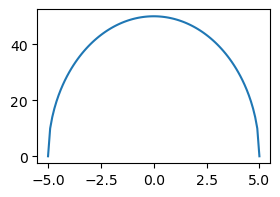

In [3]:
a = 5; 
x = -5:0.1:5;
g = 10 .* sqrt.(a^2 .- x.^2);
PyPlot.figure(1,figsize=(3,2));PyPlot.plot(x, g);

___
### **Randon Transform**

* **Sinogram**

$\;\;\;\;\;\;\;$ A way to display the Radon transform.

$\;\;\;\;\;\;\;$ CT scanner acquires data for collection of $l$ and $\theta$ (sinogram).

$\;\;\;\;\;\;\;$ <img src="sinogram.png" width="400px"/>

* **Code for generating sinogram**

In [4]:
function radon(Image,theta)
    # Padding image with zeros so information will not lose when image is rotated.
    (h, w) = size(Image);
    r = sqrt(h^2 + w^2);
    h_pad = Int(ceil(r - h) + 3);
    w_pad = Int(ceil(r - w) + 3);
    Image_pad = zeros(h + h_pad, w + w_pad);
    Image_pad[Int(ceil(h_pad / 2)):Int((ceil(h_pad / 2) + h - 1)), Int(ceil(w_pad / 2)):Int((ceil(w_pad / 2) + w - 1))] = Image;
    
    h_dim = h + h_pad;
    w_dim = w + w_pad;
    x = (LinRange(-w/2, w/2, w))' .* ones(w);
    y = ones(h)' .* LinRange(-h/2, h/2, h);
    xx = LinRange(-w_dim/2, w_dim/ 2, w_dim);
    yy = LinRange(-h_dim/2, h_dim/2, h_dim);    
    zz = Image_pad;
    itp = LinearInterpolation((xx, yy), zz);

    theta_dim = length(theta);
    pr = zeros(w_dim, theta_dim);    
    z2 = zeros(h, w);

    for k = 1 : theta_dim
        ang = theta[k] * pi / 180
        x_rot = cos(ang) .* x .+ sin(ang) .* y
        y_rot = -sin(ang) .* x .+ cos(ang) .* y
        z2_pad = zeros(h + h_pad, w + w_pad);
        
        for k1 = 1:h
            for k2 = 1:w
                z2[k1,k2] = itp(y_rot[k1,k2],x_rot[k1,k2]);
            end
        end
    
        z2_pad[Int(ceil(h_pad / 2)):Int((ceil(h_pad / 2) + h - 1)), Int(ceil(w_pad / 2)):Int((ceil(w_pad / 2) + w - 1))] = z2;
        pr[:,k] = (sum(z2_pad,dims=1))';
    end
    
    return pr
end

radon (generic function with 1 method)

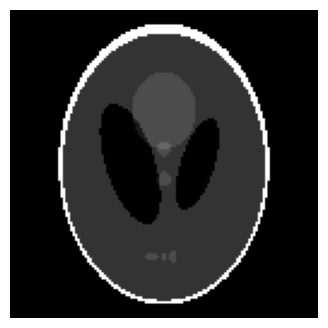

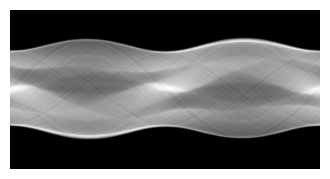

In [5]:
file = matopen("phantom.mat")
Image = read(file, "Image") # note that this does NOT introduce a variable ``varname`` into scope
close(file);

theta = 0:359;
projection = radon(Image,theta);

figure(1, figsize = (4, 4));
imshow(Image, cmap = "gray");axis("off");
figure(2, figsize = (4, 4));
imshow(projection, cmap = "gray");axis("off");

___
### **CT Reconsturction: Backprojection**

* **Backprojection**

$\;\;\;\;\;\;\;$ Goal: find $f(x,y)$ from $g(l,\theta)$

$\;\;\;\;\;\;\;$ Strategy: "smear" $g(l,\theta)$ into plane

$\;\;\;\;\;\;\;$ Formally: $b_\theta(x,y)=g(xcos\theta+ysin\theta,\theta),\;\;\;\;$  $b_\theta(x,y)$ is a laminar image

$\;\;\;\;\;\;\;$ "Add up" all the backprojection images: $f_b(x,y)=\int_{0}^{\pi} b_\theta(x,y)d\theta$



* **Code for backprojection recontruction using above generated sinogram**

In [6]:

function iradon_BP(pr, theta)
    h = Int(2 * floor(size(pr, 1) / (2 * sqrt(2))))
    w = h
    Image_BP = zeros(h, w)
    h_dim = size(pr, 1)
    w_dim = h_dim
    x = LinRange(-w_dim / 2, w_dim / 2, w_dim)
    y = LinRange(-h_dim / 2, h_dim / 2, h_dim)
    xx = (LinRange(-w / 2, w / 2, w))' .* ones(w)
    yy = ones(h) .* LinRange(-h / 2, h / 2, h)

    for k = 1:size(pr, 2)
        ang = -theta[k] * pi / 180
        x_rot = cos(ang) .* xx .+ sin(ang) .* yy
        y_rot = -sin(ang) .* xx .+ cos(ang) .* yy

        line = projection[:, k]'
        z = repeat(line, h_dim, 1)
        itp = LinearInterpolation((x, y), z)

        zz = zeros(h, w)
        for k1 = 1:h
            for k2 = 1:w
                zz[k1, k2] = itp(y_rot[k1, k2], x_rot[k1, k2])
            end
        end
        Image_BP = Image_BP + zz
    end
    return Image_BP
end

function iradon_BP(pr, pr_theta, recon_theta)
    h = Int(2 * floor(size(pr, 1) / (2 * sqrt(2))))
    w = h
    Image_BP = zeros(h, w)
    h_dim = size(pr, 1)
    w_dim = h_dim
    x = LinRange(-w_dim / 2, w_dim / 2, w_dim)
    y = LinRange(-h_dim / 2, h_dim / 2, h_dim)
    xx = (LinRange(-w / 2, w / 2, w))' .* ones(w)
    yy = ones(h) .* LinRange(-h / 2, h / 2, h)

    if length(recon_theta) == 1
        k = 1
        ang = -recon_theta[k] * pi / 180
        x_rot = cos(ang) .* xx .+ sin(ang) .* yy
        y_rot = -sin(ang) .* xx .+ cos(ang) .* yy

        if isempty(findall(t -> t == recon_theta[k], pr_theta))
            print("Error: slected theta for reconsturction is not in the range of theta in projection")
        else
            line = pr[:, findall(t -> t == recon_theta[k], pr_theta)]'
        end
        z = repeat(line, h_dim, 1)
        itp = LinearInterpolation((x, y), z)

        zz = zeros(h, w)
        for k1 = 1:h
            for k2 = 1:w
                zz[k1, k2] = itp(y_rot[k1, k2], x_rot[k1, k2])
            end
        end
        Image_BP = Image_BP + zz

    else
        for k = 1:length(recon_theta)
            ang = -recon_theta[k] * pi / 180
            x_rot = cos(ang) .* xx .+ sin(ang) .* yy
            y_rot = -sin(ang) .* xx .+ cos(ang) .* yy

            line = pr[:, findall(t -> t == recon_theta[k], pr_theta)]'
            z = repeat(line, h_dim, 1)
            itp = LinearInterpolation((x, y), z)

            zz = zeros(h, w)
            for k1 = 1:h
                for k2 = 1:w
                    zz[k1, k2] = itp(y_rot[k1, k2], x_rot[k1, k2])
                end
            end
            Image_BP = Image_BP + zz
        end
    end
    return Image_BP
end

iradon_BP (generic function with 2 methods)

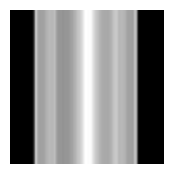

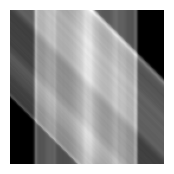

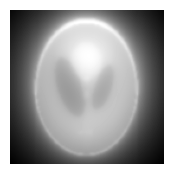

In [7]:
theta = 0:359;
theta0 = 0
Image_BP0 = iradon_BP(projection,theta,theta0);
theta1 = [0,45]
Image_BP1 = iradon_BP(projection,theta,theta1);
theta2 = 0:179
Image_BP2 = iradon_BP(projection,theta,theta2);
figure(1, figsize = (2, 2));
imshow(Image_BP0, cmap = "gray");axis("off");
figure(2, figsize = (2, 2));
imshow(Image_BP1, cmap = "gray");axis("off");
figure(3, figsize = (2, 2));
imshow(Image_BP2, cmap = "gray");axis("off");

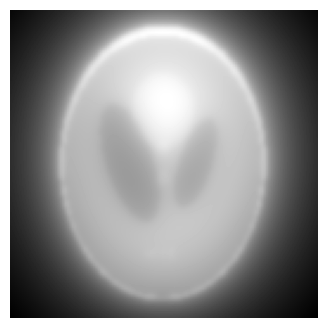

In [8]:

theta = 0:359;
Image_BP = iradon_BP(projection,theta);

figure(1, figsize = (4, 4));
imshow(Image_BP, cmap = "gray");axis("off");

* **"Bright spots" issue:**

$\;\;\;\;\;\;\;$ Backprojected image is blurred by convolution with 1/r. 

$\;\;\;\;\;\;\;$ **Where intuitively does the 1/r come from?**

$\;\;\;\;\;\;\;$ Density of radial lines on a circle goes down as 1/r as r increases. The "add-up" step causes a hot spot at central point.

$\;\;\;\;\;\;\;$ Filtered backprojection reconstruction can address this issue.

$\;\;\;\;\;\;\;$ <img src="bp_issue.png" width="400px"/>





___
### **Projection-slice Theorem (not complete)**

* **Projection-slice Theorem**

$\;\;\;\;\;\;\;$ The 1D Fourier transform of a projection is a slice of the 2D Fourier transform of the object image.

$\;\;\;\;\;\;\; G(\rho,\theta)=F(\rho cos\theta,\rho sin\theta)$


$\;\;\;\;\;\;\;$ <img src="projection-slice.png" width="500px"/>

* **Fourier reconstruction steps:**

$\;\;\;\;\;\;\;$ 1. Calculate 1D FT of each projection $G(\rho,\theta)$

$\;\;\;\;\;\;\;$ 2. Construct the 2D FT of $f(x,y)$ by interpolating the polar data $G(\rho,\theta)$ to the nearest desired retilinear grid point.

$\;\;\;\;\;\;\;$ 3. Find $f(x,y) = IFT_{2D}\left(F(u,v)\right)$

* **Code for Fourier reconsturction**

In [9]:
function qift(inputdata)
    sz = size(inputdata)
    szarray = [i for i in sz]
    szl = length(szarray)
    if szl == 2
        outputdata = fftshift(fft(ifftshift(inputdata)))
    end
    if szl > 2
        outputdata = complex(inputdata)
        for cnt = 1:cumprod(szarray[3:end])[end]
            tmp1 = fftshift(fft(ifftshift(inputdata[:, :, cnt])))
            outputdata[:, :, cnt] = tmp1
        end
    end
    return reshape(outputdata, Tuple(szarray))
end

function iradon_Fourier(pr, theta)
    h = Int(2 * floor(size(pr, 1) / (2 * sqrt(2))))
    w = h
    h_dim = size(pr, 1)
    w_dim = h_dim
    h_pad = Int(h_dim - h);
    w_pad = Int(w_dim - w); 

    rampFilter = abs.(LinRange(-1, 1, h_dim))' # ramp filter
    Image_FTrecon_ft = zeros(h_dim, w_dim)
    for k = 1:length(theta)
        ang = -theta[k] * pi / 180
        line = pr[:, k]
        line_ft = fftshift(fft(ifftshift(line)))
        Image_tmp = complex(zeros(h_dim, w_dim))
        tmp = complex(zeros(h_dim, w_dim))
        tmp[Int(ceil(h_dim / 2)), :] = line_ft' .* rampFilter
        tmp = imrotate(tmp, ang)
        (h1, w1) = size(tmp)
        if h1 > h_dim || w1 > w_dim
            # Image_tmp = tmp[Int(ceil((h1-h_dim) / 2)):Int((ceil((h1-h_dim) / 2) + h_dim - 1)),Int(ceil((w1-w_dim) / 2)):Int((ceil((w1-w_dim) / 2) + w_dim - 1))];
            Image_tmp = tmp[1:Int((ceil((h1 - h_dim) / 2) + h_dim - 1))-Int(ceil((h1 - h_dim) / 2))+1, 1:Int((ceil((w1 - w_dim) / 2) + w_dim - 1))-Int(ceil((w1 - w_dim) / 2))+1]
        end
        Image_FTrecon_ft = Image_FTrecon_ft + Image_tmp

    end
    
    tmp1 = abs.(qift(Image_FTrecon_ft))
    Image_FTrecon = tmp1[Int(ceil(h_pad/2)) : Int((ceil(h_pad/2)+h-1)),Int(ceil(w_pad/2)) : Int((ceil(w_pad/2)+w-1))];
    return Image_FTrecon
end

iradon_Fourier (generic function with 1 method)

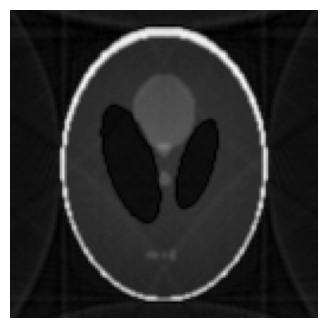

In [10]:
theta = 0 : 359
Image_FTrecon = iradon_Fourier(projection,theta);
figure(1, figsize = (4, 4));
imshow(abs.(Image_FTrecon), cmap = "gray");
axis("off");

___
### **CT Reconstruction: Filtered Backprojection**

* **Convolution backprojection**

$\;\;\;\;\;\;\;$ Correct reconsturction formula: $f(x,y)=\int_{0}^{\pi}[c(l)]*g(l,\theta)_{l=xcos{\theta}+ysin{\theta}}d{\theta} $

$\;\;\;\;\;\;\;$ where $c(l)=F^{-1}\left\{|\rho|\right\}$ is called ramp filter.
<br><br>

* **Reconstruction steps:**

$\;\;\;\;\;\;\;$ 1. Convolution: convolve every projection with $c(l)$

$\;\;\;\;\;\;\;$ 2. Backprojection: 1D projection $\rightarrow$ 2D laminar function

$\;\;\;\;\;\;\;$ 3. Summation: accumulate "smeared projections"

* **Code for filtered backprojection reconstruction**

In [11]:
function iradon_filterBP(pr, theta)
    h = Int(2 * floor(size(pr, 1) / (2 * sqrt(2))))
    w = h
    h_dim = size(pr, 1)
    w_dim = h_dim

    x = LinRange(-w_dim / 2, w_dim / 2, w_dim)
    y = LinRange(-h_dim / 2, h_dim / 2, h_dim)
    xx = (LinRange(-w / 2, w / 2, w))' .* ones(w)
    yy = ones(h) .* LinRange(-h / 2, h / 2, h)

    rampFilter = abs.(LinRange(-1, 1, h_dim)) # ramp filter

    Image_filterBP = zeros(h, w)
    for k = 1:size(pr, 2)
        ang = (-theta[k]) * pi / 180
        x_rot = cos(ang) .* xx .+ sin(ang) .* yy
        y_rot = -sin(ang) .* xx .+ cos(ang) .* yy

        line = fftshift(fft(ifftshift(pr[:, k]))) .* rampFilter
        line1 = fftshift(ifft(ifftshift(line)))

        z = repeat(line1', h_dim, 1)
        itp = LinearInterpolation((x, y), z)
        zz = complex(zeros(h, w))
        for k1 = 1:h
            for k2 = 1:w
                zz[k1,k2] = itp(y_rot[k1,k2],x_rot[k1,k2]);
            end
        end
        Image_filterBP = Image_filterBP + zz
    end
    return Image_filterBP
end

iradon_filterBP (generic function with 1 method)

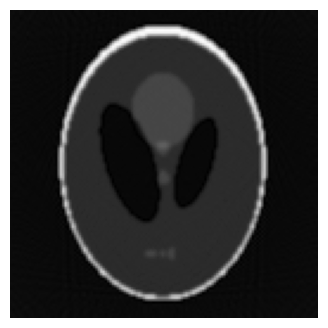

In [12]:
Image_filterBP = iradon_filterBP(projection,theta);
figure(1, figsize = (4, 4));
imshow(abs.(Image_filterBP), cmap = "gray");
axis("off");
